In [2]:
import argparse
import torch as th
import torch.nn as nn
import torchvision as tv
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassConfusionMatrix
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import numpy as np

import time
import wandb
import random
import os
import argparse

print("Torch version:", th.__version__)

Torch version: 2.2.2


In [4]:
data_dir = "C:\\Users\\BenaventeD\\data\\s-mad-dataset\\preprocessed-frgc\\dataset_test\\"
# data_dir = "C:\\Users\\BenaventeD\\data\\s-mad-dataset\\FERET\\npp\\dataset_test"
num_epochs = 3
batch_size = 256
img_size = 224
class_num = 6
lr = .0003
model = "efficientnetb3"
weights_path = "C:\\Users\\BenaventeD\\Projects\\project_smad\\efficientnetb3_3.pt"

In [17]:
#########################################################
if th.cuda.is_available():
  device = "cuda:0"
else:
  device = "cpu"
#########################################################
if os.path.exists(data_dir):
   test_path = "C:\\Users\\BenaventeD\\data\\s-mad-dataset\\FERET\\npp\\dataset_test" # os.path.join(data_dir, "test")
   if os.path.exists(test_path):
     transf = v2.Compose([
                        v2.Resize(size=(img_size,img_size)),
                        v2.RandomHorizontalFlip(p=.5),
                        v2.ToTensor(),
                        ])
     test_data = ImageFolder(root=test_path, transform=transf, 
                        )
     test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
   else:
      raise Exception("The test path doesn't exist") 
else:
    raise Exception("The data dir doesn't exist")

c:\Users\BenaventeD\anaconda3\envs\project_smad\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [7]:
############ Models ##################
if model == "efficientnetb3":
    model_name = model
    ######## EfficientNet B3 #############
    model = tv.models.efficientnet_b3(weights='IMAGENET1K_V1')
    model.classifier = nn.Sequential(
                                                nn.Dropout(p=.2, inplace=True),
                                                nn.Linear(in_features=1536, out_features=class_num, bias=True),
                                                nn.Softmax(dim=1)
                                                )
    model.to(device)
elif model == 'mobilenetv3':
    model_name = model
    ######## MobileNet V3 #############
    model = tv.models.mobilenet_v3_large(weights='IMAGENET1K_V1')
    model.classifier = nn.Sequential(
                                                    nn.Linear(in_features=960, out_features=1280, bias=True),
                                                    nn.Hardswish(inplace=True),
                                                    nn.Dropout(p=.2, inplace=True),
                                                    nn.Linear(in_features=1280, out_features=class_num, bias=True),
                                                    nn.Softmax(dim=1)
                                                )
    model.to(device)
elif model == 'swin_transformer':
    model_name = model
    ######## Swin Transformer #############
    model = tv.models.swin_t(weights='IMAGENET1K_V1')
    print('Head classifier:', model.head)
    model.head = nn.Sequential(
                                nn.Linear(in_features=768, out_features=class_num, bias=True),
                                nn.Softmax(dim=1)
                                            )
    model.to(device)
model.load_state_dict(th.load(weights_path))

<All keys matched successfully>

In [36]:
#######################################
# Criterion
loss_fn = nn.CrossEntropyLoss().to(device)
# Metric
conf_matrix = MulticlassConfusionMatrix(num_classes=class_num)
#######################################
startTime = time.time()
print("[INFO] training the network: {:.2f}s".format(startTime))

model.eval()
test_losses = np.array([])
for batch, labels in (pbar:= tqdm(test_loader, desc="Batch", position=0)):
   with th.no_grad():
        batch = batch.to(device)
        labels = labels.to(device)
        transformed = model.forward(batch)
        loss = loss_fn(transformed, labels).to(device)
        test_losses = np.append(test_losses, loss.detach().cpu())
conf_matrix_ = conf_matrix(th.argmax(input=transformed, dim=1), labels)
        # break
print(f'\t test loss: {np.sum(test_losses) / len(test_losses)}')
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime)) 

[INFO] training the network: 1715762029.14s


Batch:   0%|          | 0/15 [00:00<?, ?it/s]

	 test loss: 1.8026577234268188
[INFO] total time taken to train the model: 361.54s


In [52]:
len(test_losses)

15

In [48]:
batch.size()

torch.Size([119, 3, 224, 224])

In [49]:
labels.size()

torch.Size([119])

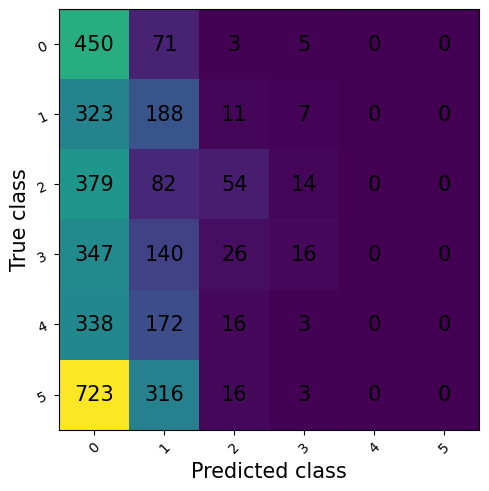

In [47]:
fig_, ax_ = conf_matrix.plot()